# Fourier slice integration

In [1]:
import jax.numpy as jnp
from matplotlib import pyplot as plt

import cryojax.simulator as cxs
from cryojax.io import read_atoms_from_pdb


atom_positions, atom_identities, b_factors = read_atoms_from_pdb(
    "./data/5w0s.pdb",
    center=True,
    select="not element H",
    loads_b_factors=True,
)
atom_potential = cxs.PengAtomicPotential(atom_positions, atom_identities, b_factors)

# Multislice integrator

In [2]:
dim, pixel_size = 150, 2.0
instrument_config = cxs.InstrumentConfig(
    shape=(dim, dim),
    pixel_size=pixel_size,
    voltage_in_kilovolts=300.0,
)
voxel_potential = cxs.FourierVoxelGridPotential.from_real_voxel_grid(
    atom_potential.as_real_voxel_grid((dim, dim, dim), pixel_size), pixel_size
)

In [3]:
# voxel_potential = cxs.RealVoxelGridPotential.from_real_voxel_grid(
#    atom_potential.as_real_voxel_grid((150, 150, 150), instrument_config.pixel_size),
#    instrument_config.pixel_size,
# )

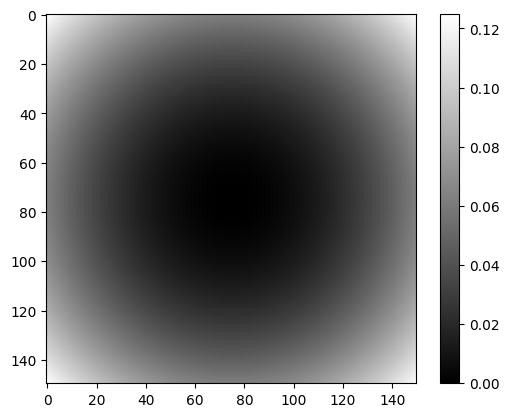

In [4]:
kx, ky = instrument_config.padded_full_frequency_grid_in_angstroms.T
k2 = jnp.hypot(kx, ky) ** 2
plt.imshow(jnp.fft.fftshift(k2), cmap="gray")
plt.colorbar()

In [5]:
from cryojax.experimental import FFTMultisliceIntegrator

In [6]:
multislice_integrator = FFTMultisliceIntegrator(
    slice_thickness_in_voxels=3,
)

# exit_wave = multislice_integrator.compute_wavefunction_at_exit_plane(
#    atom_potential, instrument_config
# )
# fig, axes = plt.subplots(1, 2, figsize=(10, 5))
# im0 = axes[0].imshow(exit_wave.real, cmap="gray")
# fig.colorbar(im0, ax=axes[0])
#
# im1 = axes[1].imshow(exit_wave.imag, cmap="gray")
# fig.colorbar(im1, ax=axes[1])

In [7]:
pose = cxs.EulerAnglePose(
    offset_x_in_angstroms=12.0,
    offset_y_in_angstroms=-14.0,
    theta_angle=90.0,
    psi_angle=20.0,
    phi_angle=0.0,
)
# structural_ensemble = cxs.SingleStructureEnsemble(voxel_potential, pose)
structural_ensemble = cxs.SingleStructureEnsemble(atom_potential, pose)

ctf = cxs.ContrastTransferFunction(
    defocus_in_angstroms=10000.0,
    astigmatism_in_angstroms=-100.0,
    astigmatism_angle=10.0,
)

In [ ]:
import cryojax.experimental as cxe


ac = 0.3
multislice_scattering_theory = cxe.MultisliceScatteringTheory(
    structural_ensemble,
    multislice_integrator,
    cxe.WaveTransferTheory(ctf),
    amplitude_contrast_ratio=ac,
)
high_energy_scattering_theory = cxe.HighEnergyScatteringTheory(
    structural_ensemble,
    cxs.GaussianMixtureProjection(use_error_functions=True),
    cxe.WaveTransferTheory(ctf),
    amplitude_contrast_ratio=ac,
)
weak_phase_scattering_theory = cxs.WeakPhaseScatteringTheory(
    structural_ensemble,
    cxs.GaussianMixtureProjection(use_error_functions=True),
    cxs.ContrastTransferTheory(ctf, amplitude_contrast_ratio=ac, phase_shift=0.0),
)

In [9]:
multislice_image_model = cxs.ContrastImageModel(
    instrument_config, multislice_scattering_theory
)
high_energy_image_model = cxs.ContrastImageModel(
    instrument_config, high_energy_scattering_theory
)
weak_phase_image_model = cxs.ContrastImageModel(
    instrument_config, weak_phase_scattering_theory
)

im1, im2, im3 = (
    multislice_image_model.render(),
    high_energy_image_model.render(),
    weak_phase_image_model.render(),
)

Mins (Array(-0.16553108, dtype=float32), Array(-0.16442348, dtype=float32), Array(-0.1681118, dtype=float32))
Maxes (Array(0.07200963, dtype=float32), Array(0.07293716, dtype=float32), Array(0.08005343, dtype=float32))


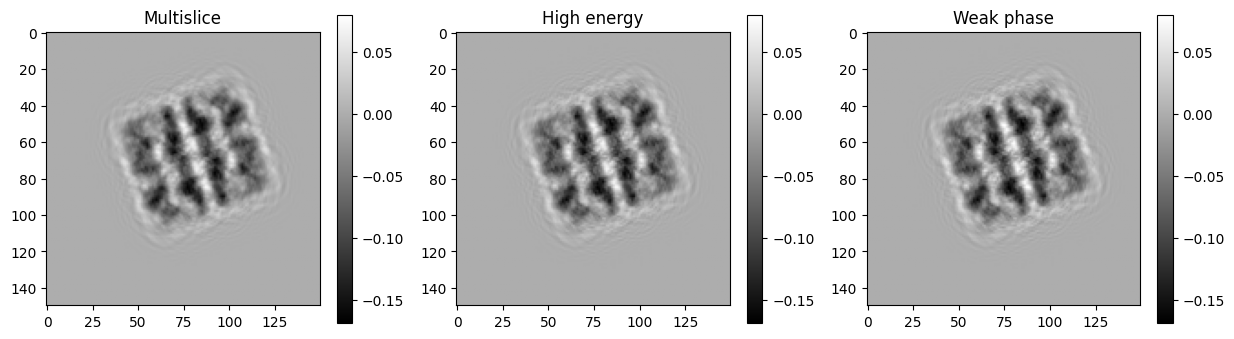

In [10]:
import numpy as np


mins = np.amin(im1), np.amin(im2), np.amin(im3)
maxes = np.amax(im1), np.amax(im2), np.amax(im3)
print("Mins", mins)
print("Maxes", maxes)
fig, axes = plt.subplots(ncols=3, figsize=(15, 4))
vmin, vmax = min(*mins), max(*maxes)
m1 = axes[0].imshow(im1, cmap="gray", vmin=vmin, vmax=vmax)
m2 = axes[1].imshow(im2, cmap="gray", vmin=vmin, vmax=vmax)
m3 = axes[2].imshow(im3, cmap="gray", vmin=vmin, vmax=vmax)
axes[0].set(title="Multislice")
axes[1].set(title="High energy")
axes[2].set(title="Weak phase")
fig.colorbar(m1)
fig.colorbar(m2)
fig.colorbar(m3)